In [1]:
import os
os.chdir("/afs/csail.mit.edu/u/s/samsl/Work/Adapting_PLM_DTI")

In [2]:
import torch
device = torch.device("cuda:7")

from src.featurizers import (
    ESMFeaturizer,
    ProtBertFeaturizer,
    MorganFeaturizer,
)
from src.data import (
    get_task_dir,
    DTIDataModule,
)
from src.utils import (
    set_random_seed,
    get_logger,
)
from src.architectures import SimpleCoembedding

In [18]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import KFold
from collections import defaultdict
from collections.abc import Iterable
from tqdm.notebook import tqdm

In [4]:
seed = 61998

set_random_seed(seed)
logg = get_logger()

In [5]:
TASK = "davis"

In [6]:
task_dir = get_task_dir(TASK)

drug_featurizer = MorganFeaturizer(save_dir=task_dir)
# target_featurizer = ESMFeaturizer(save_dir=task_dir)
target_featurizer = ProtBertFeaturizer(save_dir=task_dir)

datamodule = DTIDataModule(
    task_dir,
    drug_featurizer,
    target_featurizer,
    device=device,
)
datamodule.setup()

ProtBert: 100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:00<00:00, 1315.18it/s]


## All But DUDe

In [7]:
protbert_featurizer = ProtBertFeaturizer(save_dir=task_dir)

cpi_model = SimpleCoembedding(
        2048,
        1024,
        latent_dimension=1024,
        latent_distance="Cosine",
        classify=True,
    ).to(device)

state_dict = torch.load("best_models/davis_contrastive_batch128_best_model.pt")
# state_dict = torch.load("best_models/bindingdb_contrastive_best_model.pt")
# state_dict = torch.load("best_models/biosnap_contrastive_best_model.pt")
# state_dict = torch.load("best_models/new_proteins_contrastive_best_model.pt")

cpi_model.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
def calc_coverage(
    df,
    drug_col = "SMILES",
    target_col = "Target Sequence",
    label_col = "Label"
):
    drug_uniq = df[drug_col].unique()
    target_uniq = df[target_col].unique()

    coverage_mtx = np.zeros((len(drug_uniq), len(target_uniq)))

    for i, d in tqdm(enumerate(drug_uniq),leave=False, total=len(drug_uniq)):
        for j, t in enumerate(target_uniq):
            obs_df = df[(df[drug_col] == d) & (df[target_col] == t)]
            n_obs = len(obs_df)
            coverage_mtx[i,j] = n_obs

    return coverage_mtx

def viz_coverage(
    df,
    drug_col = "SMILES",
    target_col = "Target Sequence",
    label_col = "Label",
    binary = True,
    precomputed = None,
    key = ''
):
    if precomputed is None:
        coverage_mtx = calc_coverage(df, drug_col, target_col, label_col)
    else:
        coverage_mtx = precomputed
    cmap = 'hot'
    vmin = coverage_mtx.min()
    vmax = coverage_mtx.max()
    if binary:
        coverage_mtx = (coverage_mtx > 0).astype(int)
        cmap = 'binary'
        vmin = 0
        vmax = 1
    drug_uniq = df[drug_col].unique()
    target_uniq = df[target_col].unique()
    df = pd.DataFrame(coverage_mtx, index = drug_uniq, columns = target_uniq)

    sns.set(rc={'figure.figsize':(11.7,8.27)}, style="whitegrid")
    sns.heatmap(df, xticklabels=False, yticklabels=False,cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(f"{key} Drug x Target Coverage")
    plt.ylabel("Drug")
    plt.xlabel("Target")
    plt.savefig(f"img/{key}_coverage_drugxtarget.png",bbox_inches='tight')
    plt.show()
    # plt.close()
    
    binary_cov = (coverage_mtx > 0).astype(int)
    drug_cov = binary_cov.mean(axis=1)
    target_cov = binary_cov.mean(axis=0)

    coverages = np.concatenate([drug_cov, target_cov])
    labels = ["Drug"] * len(drug_cov) + ["Target"] * len(target_cov)
    covg_df = pd.DataFrame({"Coverage": coverages, "Type":labels})
    # sns.displot(covg_df, x="Coverage", hue="Type")
    sns.boxplot(x=covg_df["Coverage"],y=covg_df["Type"])
    plt.title(f"{key} Distribution of Coverages")
    plt.xlim(0,1)
    # plt.savefig(f"img/{key}_coverage_distribution.png",bbox_inches='tight')
    plt.show()
    # plt.close()

In [9]:
drug_column = datamodule._drug_column
target_column = datamodule._target_column
label_column = datamodule._label_column

In [10]:
train_df = datamodule.df_train
test_df = datamodule.df_test
full_df = pd.concat([datamodule.df_train, datamodule.df_test])

drug_uniq = full_df[drug_column].unique()
target_uniq = full_df[target_column].unique()

In [11]:
target_featurizer.preload(target_uniq)
protbert_featurizer.preload(target_uniq)
drug_featurizer.preload(drug_uniq)

Morgan: 100%|███████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 4145.59it/s]


In [12]:
def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

  0%|          | 0/68 [00:00<?, ?it/s]

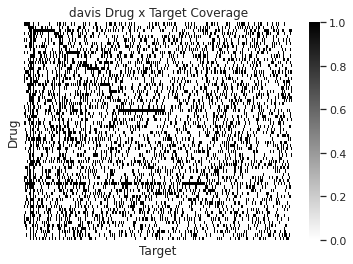

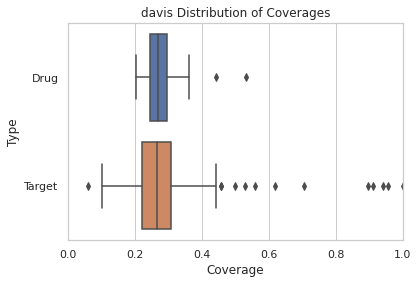

In [13]:
viz_coverage(full_df, drug_column, target_column, label_column, key = TASK)

In [19]:
dset_sizes = {}

all_predictions = defaultdict(list)
all_cpi_predictions = defaultdict(list)
all_labels = defaultdict(list)
task_aupr_dict = {}
cpi_aupr_dict = {}

skipped = 0
train_only = 0

for curr_task in tqdm(drug_uniq,total=len(drug_uniq)):

    drug_feat = drug_featurizer(curr_task)
    
    train_df_task = train_df[train_df[drug_column] == curr_task]
    test_df_task = test_df[test_df[drug_column] == curr_task]
    
    dset_sizes[curr_task] = (len(train_df_task), len(test_df_task))
    if (len(train_df_task) < 1) or (len(test_df_task) < 1):
        if curr_task in test_df[drug_column].unique():
            skipped += 1
        else:
            train_only += 1
        continue
    
    model = Ridge()

    train_X = []
    for i, r in train_df_task.iterrows():
        train_X.append(target_featurizer(r[target_column]))
    train_X = torch.stack(train_X, 0).detach().cpu().numpy()
    train_Y = train_df_task[label_column].values
    assert len(train_X) == len(train_Y)

    model.fit(train_X, train_Y)

    test_X = []
    cpi_test_drugX = []
    cpi_test_targX = []
    for i, r in test_df_task.iterrows():
        esm_feat = target_featurizer(r[target_column])
        protbert_feat = protbert_featurizer(r[target_column])
        test_X.append(esm_feat)
        cpi_test_drugX.append(drug_feat.to(device))
        cpi_test_targX.append(protbert_feat.to(device))
    test_X = torch.stack(test_X).detach().cpu().numpy()
    test_Y = test_df_task[label_column].values

    prd = model.predict(test_X)
    with torch.set_grad_enabled(False):
        prd_cpi = cpi_model(torch.stack(cpi_test_drugX,0), torch.stack(cpi_test_targX,0))
    
    all_labels[curr_task].append(test_Y)
    all_predictions[curr_task].append(prd)
    if not prd_cpi.shape:
        prd_cpi = torch.Tensor([prd_cpi.item()]).cpu()
    all_cpi_predictions[curr_task] = prd_cpi
    
    labels = list(flatten(all_labels[curr_task]))
    predictions = list(flatten(all_predictions[curr_task]))
    predictions_cpi = all_cpi_predictions[curr_task].cpu()
    curr_aupr = average_precision_score(labels, predictions)
    cpi_aupr = average_precision_score(labels, predictions_cpi)
    task_aupr_dict[curr_task] = curr_aupr
    cpi_aupr_dict[curr_task] = cpi_aupr

  0%|          | 0/68 [00:00<?, ?it/s]

In [20]:
print(f"Total drugs in training set: {len(drug_uniq)}")
print(f"Train only tasks: {train_only}")
print(f"Number of test tasks skipped: {skipped}")
print(f"Pct of test tasks skipped: {skipped / len(test_df[drug_column].unique()):.2%}")

Total drugs in training set: 68
Train only tasks: 0
Number of test tasks skipped: 0
Pct of test tasks skipped: 0.00%


In [21]:
task_auprs = list(task_aupr_dict.values())
avg_of_avg = np.nanmean(task_auprs)
print(f"Average per-task AUPR (Single Task): {avg_of_avg}")

cpi_task_auprs = list(cpi_aupr_dict.values())
cpi_avg_of_avg = np.nanmean(cpi_task_auprs)
print(f"Average per-task AUPR (CPI): {cpi_avg_of_avg}")

Average per-task AUPR (Single Task): 0.47779589060682476
Average per-task AUPR (CPI): 0.5234103572806124


In [22]:
labels = list(flatten(list(all_labels.values())))
preds = list(flatten(list(all_predictions.values())))
overall_aupr = average_precision_score(labels, preds)
print(f"Overall AUPR (Single Task): {overall_aupr}")

cpi_labels = list(flatten(list(all_labels.values())))
cpi_preds = torch.cat([t.cpu() for t in list(all_cpi_predictions.values())])
cpi_overall_aupr = average_precision_score(cpi_labels, cpi_preds)
print(f"Overall AUPR (CPI): {cpi_overall_aupr}")

Overall AUPR (Single Task): 0.31958204882343616
Overall AUPR (CPI): 0.5062855274195841


-----

## DUDe

In [23]:
import torch
device = torch.device(0)

In [24]:
drug_featurizer = drug_featurizer.cuda(device)
target_featurizer = target_featurizer.cuda(device)

In [25]:
fulldf = pd.read_csv('dataset/DUDe/full.tsv',sep='\t')
splitdf = pd.read_csv('dataset/DUDe/dude_within_type_train_test_split.csv',header=None)

In [26]:
fulldf = fulldf[fulldf['Target_ID'].isin(splitdf[0])]
train_df = fulldf[fulldf['Target_ID'].isin(splitdf[splitdf[1] == 'train'][0])]
test_df = fulldf[fulldf['Target_ID'].isin(splitdf[splitdf[1] == 'test'][0])]

In [54]:
target_uniq = fulldf['Target_ID'].unique()
print(len(target_uniq))

seq_uniq = fulldf['Target_Seq'].unique()
print(len(seq_uniq))

drug_uniq = fulldf['Molecule_ID'].unique()
print(len(drug_uniq))

smile_uniq = fulldf['Molecule_SMILES'].unique()
print(len(smile_uniq))

57
57
788572
689002


In [55]:
target_featurizer.preload(seq_uniq)

ProtBert: 100%|███████████████████████████████████████████████████████████████████████████| 57/57 [00:04<00:00, 12.59it/s]


In [56]:
drug_featurizer.preload(smile_uniq)

Morgan: 100%|███████████████████████████████████████████████████████████████████| 689002/689002 [08:51<00:00, 1295.75it/s]


In [57]:
drug_column = 'Molecule_SMILES'
target_column = 'Target_Seq'
label_column = 'Label'

In [58]:
from sklearn.model_selection import train_test_split

In [60]:
seq_train = train_df['Target_Seq'].unique()

In [ ]:
dset_sizes = {}

all_predictions = defaultdict(list)
all_cpi_predictions = defaultdict(list)
all_labels = defaultdict(list)
task_aupr_dict = {}
cpi_aupr_dict = {}

skipped = 0
train_only = 0

with torch.set_grad_enabled(False):
    for curr_task in tqdm(seq_uniq,total=len(seq_uniq)):

        target_feat = target_featurizer(curr_task)

        curr_target_df = fulldf[fulldf['Target_Seq'] == curr_target]
        curr_target_pos = curr_target_df[curr_target_df['Label'] == 1]
        known_positive = curr_target_pos['Molecule_SMILES']
        negative = pd.Series(list(set(smile_uniq).difference(known_positive)))

        curr_target_all = pd.DataFrame({
            'Target_Seq': [curr_target]*(len(known_positive)+len(negative)),
            'Molecule_SMILES': pd.concat([known_positive,negative]),
            'Label': [1]*len(known_positive) + [0]*len(negative)
        })

        train_df_task, test_df_task = train_test_split(curr_target_all, test_size=0.2, stratify=curr_target_all['Label'])

        dset_sizes[curr_task] = (len(train_df_task), len(test_df_task))
        if (len(train_df_task) < 1) or (len(test_df_task) < 1):
            if curr_task in test_df[drug_column].unique():
                skipped += 1
            else:
                train_only += 1
            continue

        model = Ridge()

        train_X = []
        for i, r in train_df_task.iterrows():
            train_X.append(drug_featurizer(r[drug_column]).detach().cpu().numpy())
        train_X = np.stack(train_X)
        train_Y = train_df_task[label_column].values
        assert len(train_X) == len(train_Y)

        model.fit(train_X, train_Y)

        test_X = []
        cpi_test_drugX = []
        cpi_test_targX = []
        for i, r in test_df_task.iterrows():
            morgan_feat = drug_featurizer(r[drug_column])
            test_X.append(morgan_feat.detach().cpu().numpy())
            # cpi_test_drugX.append(morgan_feat.to(device))
            # cpi_test_targX.append(target_feat.to(device))
        test_X = np.stack(test_X)
        test_Y = test_df_task[label_column].values

        prd = model.predict(test_X)
        # with torch.set_grad_enabled(False):
            # prd_cpi = cpi_model(torch.stack(cpi_test_drugX,0), torch.stack(cpi_test_targX,0))

        all_labels[curr_task].append(test_Y)
        all_predictions[curr_task].append(prd)
        # if not prd_cpi.shape:
            # prd_cpi = torch.Tensor([prd_cpi.item()]).cpu()
        # all_cpi_predictions[curr_task] = prd_cpi

        labels = list(flatten(all_labels[curr_task]))
        predictions = list(flatten(all_predictions[curr_task]))
        # predictions_cpi = all_cpi_predictions[curr_task].cpu()
        curr_aupr = average_precision_score(labels, predictions)
        # cpi_aupr = average_precision_score(labels, predictions_cpi)
        task_aupr_dict[curr_task] = curr_aupr
        # cpi_aupr_dict[curr_task] = cpi_aupr

  0%|          | 0/57 [00:00<?, ?it/s]

In [72]:
task_auprs = list(task_aupr_dict.values())
avg_of_avg = np.nanmean(task_auprs)
print(f"Average per-task AUPR (Single Task): {avg_of_avg}")

# cpi_task_auprs = list(cpi_aupr_dict.values())
# cpi_avg_of_avg = np.nanmean(cpi_task_auprs)
# print(f"Average per-task AUPR (CPI): {cpi_avg_of_avg}")

Average per-task AUPR (Single Task): 0.8137930073706564


In [73]:
labels = list(flatten(list(all_labels.values())))
preds = list(flatten(list(all_predictions.values())))
overall_aupr = average_precision_score(labels, preds)
print(f"Overall AUPR (Single Task): {overall_aupr}")

# cpi_labels = list(flatten(list(all_labels.values())))
# cpi_preds = torch.cat([t.cpu() for t in list(all_cpi_predictions.values())])
# cpi_overall_aupr = average_precision_score(cpi_labels, cpi_preds)
# print(f"Overall AUPR (CPI): {cpi_overall_aupr}")

Overall AUPR (Single Task): 0.8103770627322873
